In [15]:
import sys

sys.path.append("../")
from config.get_config import get_config

# Load Data

In [16]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import mlflow

from sklearn.metrics import mean_squared_error, r2_score

In [17]:
sys.path.append("../src")
from pipeline.factory import Factory
from preprocessing.process_raw_data import load_data

config = dict(get_config())
data_config = dict(config["data"])

mlflow.set_tracking_uri("http://0.0.0.0:5000")
e = mlflow.set_experiment(data_config["mlflow_experiment_name"])

In [18]:
# fix paths
for k, v in data_config["paths"].items():
    if k == "scaler" or k == "optim":
        continue
    for k2, v2 in v.items():
        data_config["paths"][k][k2] = "../" + v2

In [19]:
df = load_data(data_config["paths"])
f = Factory(data_config)
f.fit(df)

Fitting data ...


/home/acaille/.cache/pypoetry/virtualenvs/stores-sales-forecasting-poc-oU5uZx8Y-py3.10/lib/python3.10/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/acaille/.cache/pypoetry/virtualenvs/stores-sales-forecasting-poc-oU5uZx8Y-py3.10/lib/python3.10/site-packages/pandas/core/generic.py:6915: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


## Data Viz

In [20]:
train, val = f.get_df()
data = pd.concat([train, val])

In [21]:
train.head()

,onpromotion,dcoilwtico,sales,typedays_Additional,typedays_Event,typedays_Holiday,typedays_Normal
2013-01-01,0.0,0.792965,2511.618999,False,False,True,False
2013-01-02,0.0,0.792965,496092.417944,False,False,False,True
2013-01-03,0.0,0.790951,361461.231124,False,False,False,True
2013-01-04,0.0,0.792728,354459.677093,False,False,False,True
2013-01-05,0.0,0.793044,348347.385084,False,False,False,True


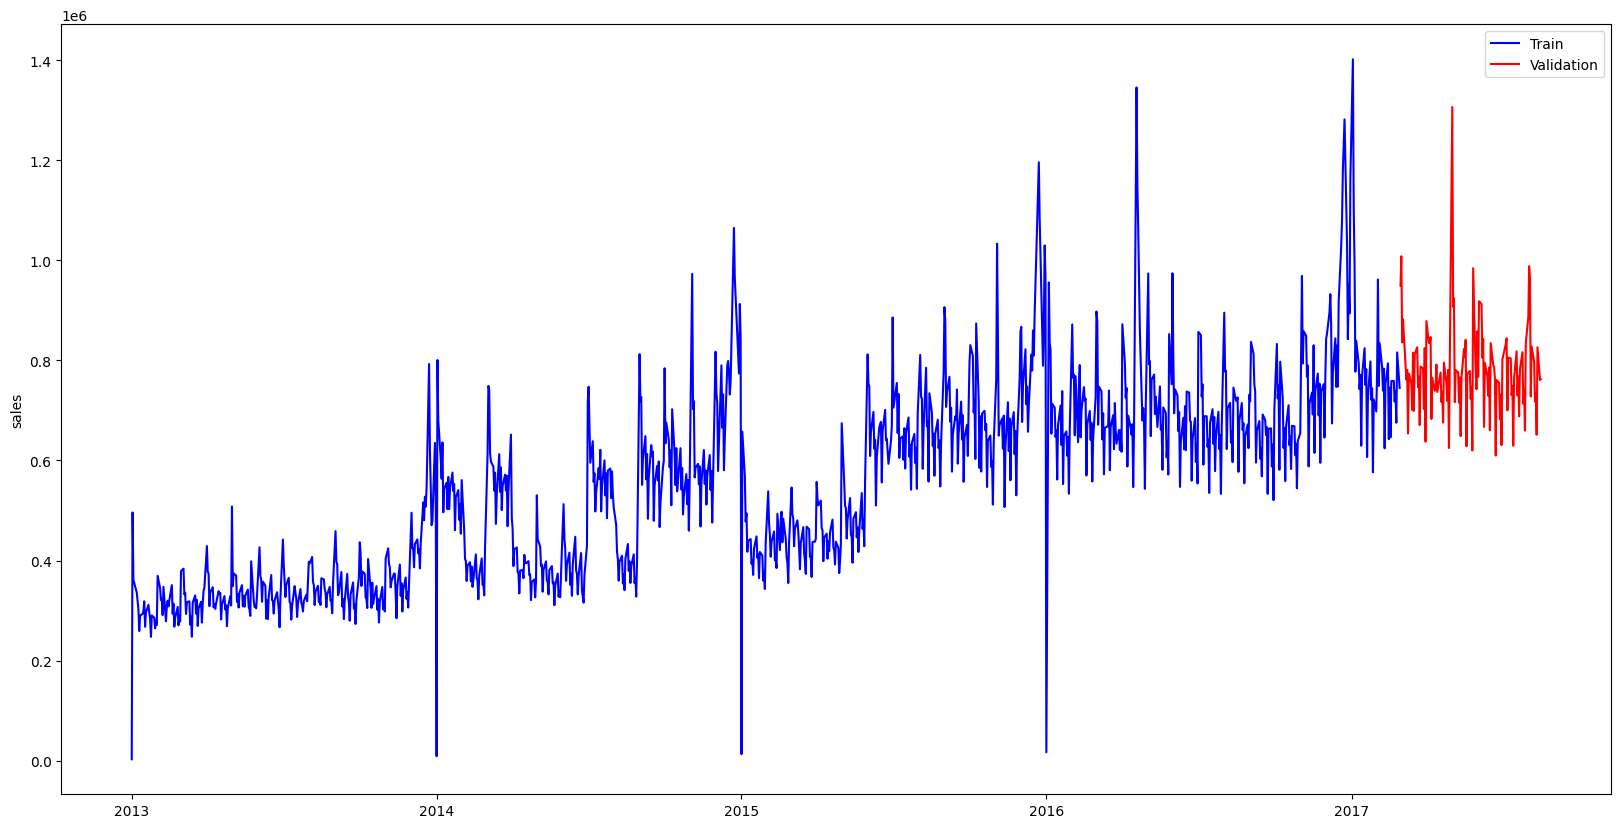

In [22]:
plt.figure(figsize=(20, 10))
sns.lineplot(data=train, x=train.index, y="sales", color="blue", label="Train")
sns.lineplot(data=val, x=val.index, y="sales", color="red", label="Validation")
plt.legend()

# Models fit

In [23]:
def predict_and_plot(model_name):
    model_type = model_name.split(" ")[0]
    model = model_name.split(" ")[1]
    id = (
        mlflow.search_registered_models(filter_string=f"name = '{model_name}'")[0]
        .latest_versions[0]
        .run_id
    )
    local_config = config[model_type][model]

    f.load_model(id, local_config)
    pred = f.predict()

    print(f"Predicted {len(pred)} days")

    assert len(pred) == len(val)

    df = pd.DataFrame(pred, columns=["yhat"])
    plt.figure(figsize=(20, 10))
    sns.lineplot(
        data=df, x=val.index, y="yhat", color="red", label=f"{model_type} Prediction"
    )
    sns.lineplot(data=val, x=val.index, y="sales", color="blue", label="Validation")

    print(f"RMSE: {mean_squared_error(val['sales'], pred)}")
    
    r2 = r2_score(val['sales'], pred)
    print(f"R2: {r2}")

    
    return pred

Predicted 169 days
RMSE: 13216288608.80883
R2: 0.7179286186103839


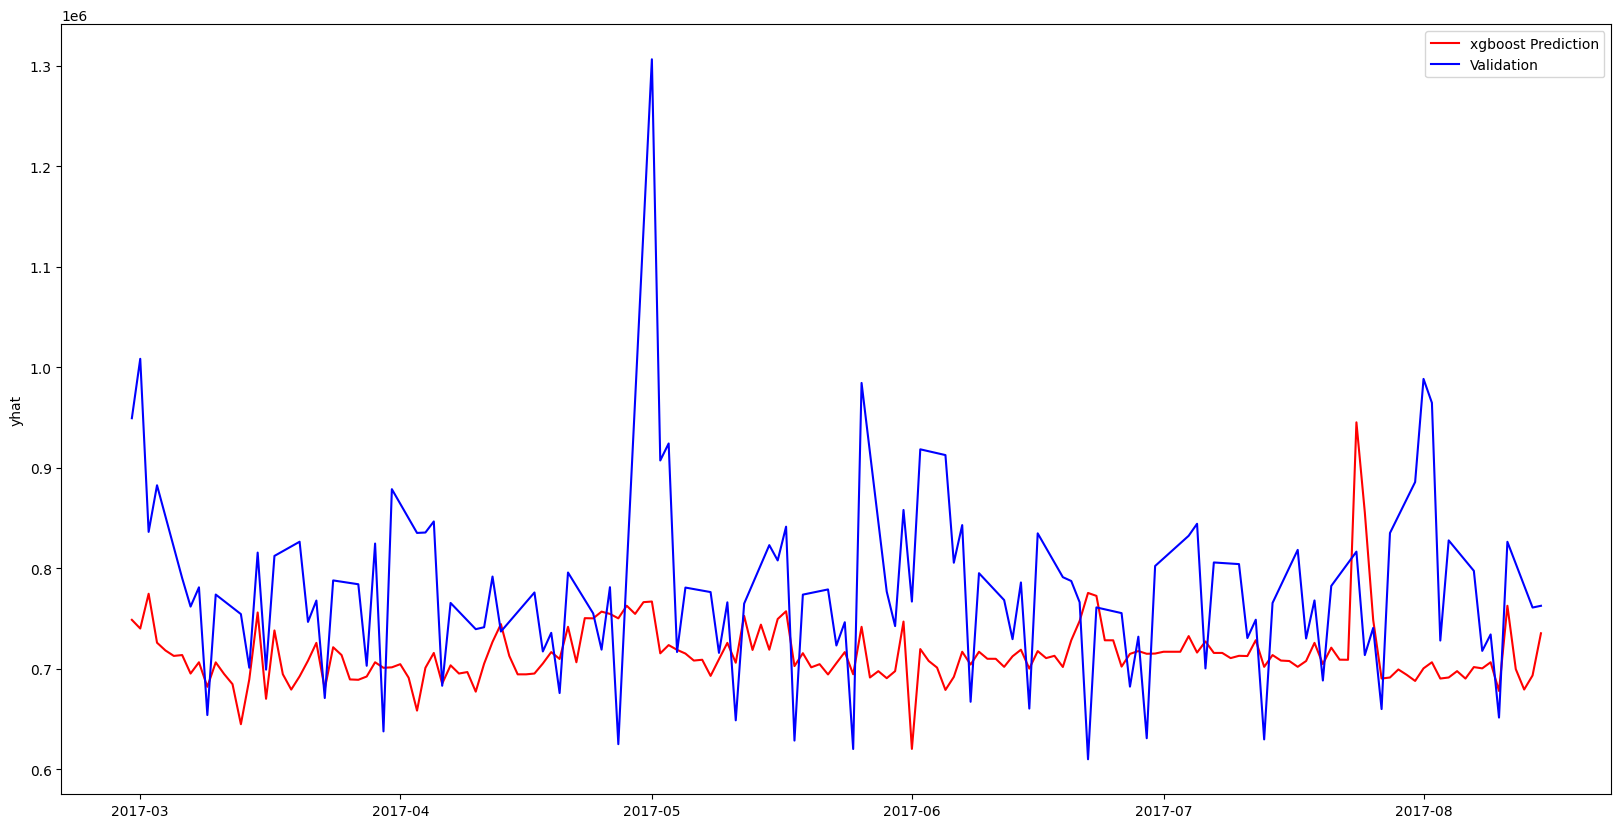

In [12]:
# Modele avec dataframe de base (sans feature engineering sur les dates ni moving average)
pred = predict_and_plot("xgboost default - 2024-02-12 14:25")

Predicted 169 days
RMSE: 14603466032.363157
R2: 0.8982418567327601


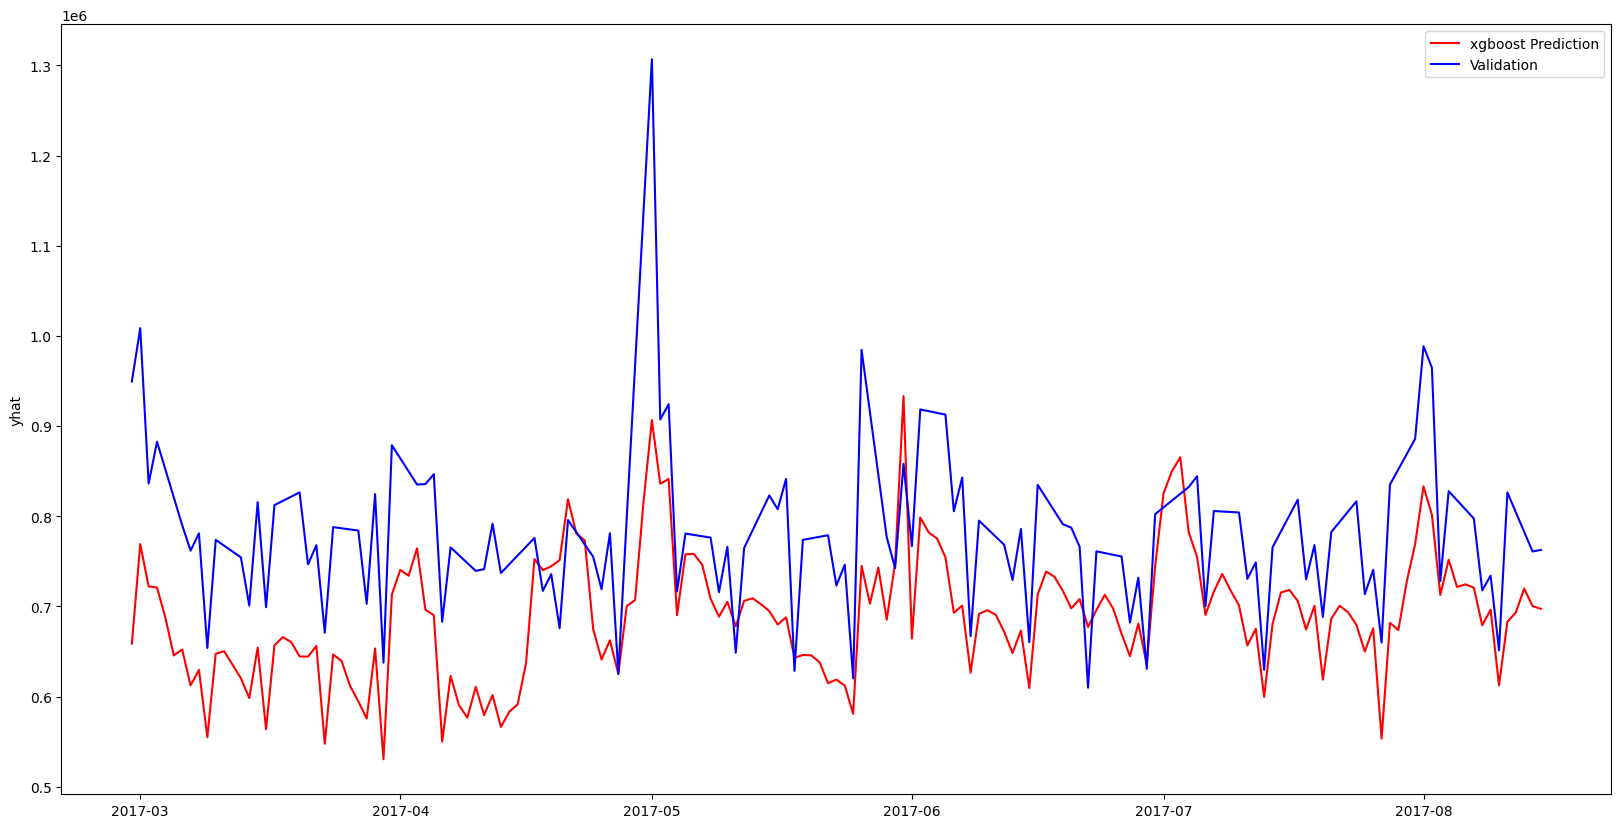

In [10]:
# Modele avec dataframe de base w/ feature engineering sur les dates
pred = predict_and_plot("xgboost default - 2024-02-12 17:44")

Predicted 169 days
RMSE: 7196314373.905072
R2: -0.06458198837994111


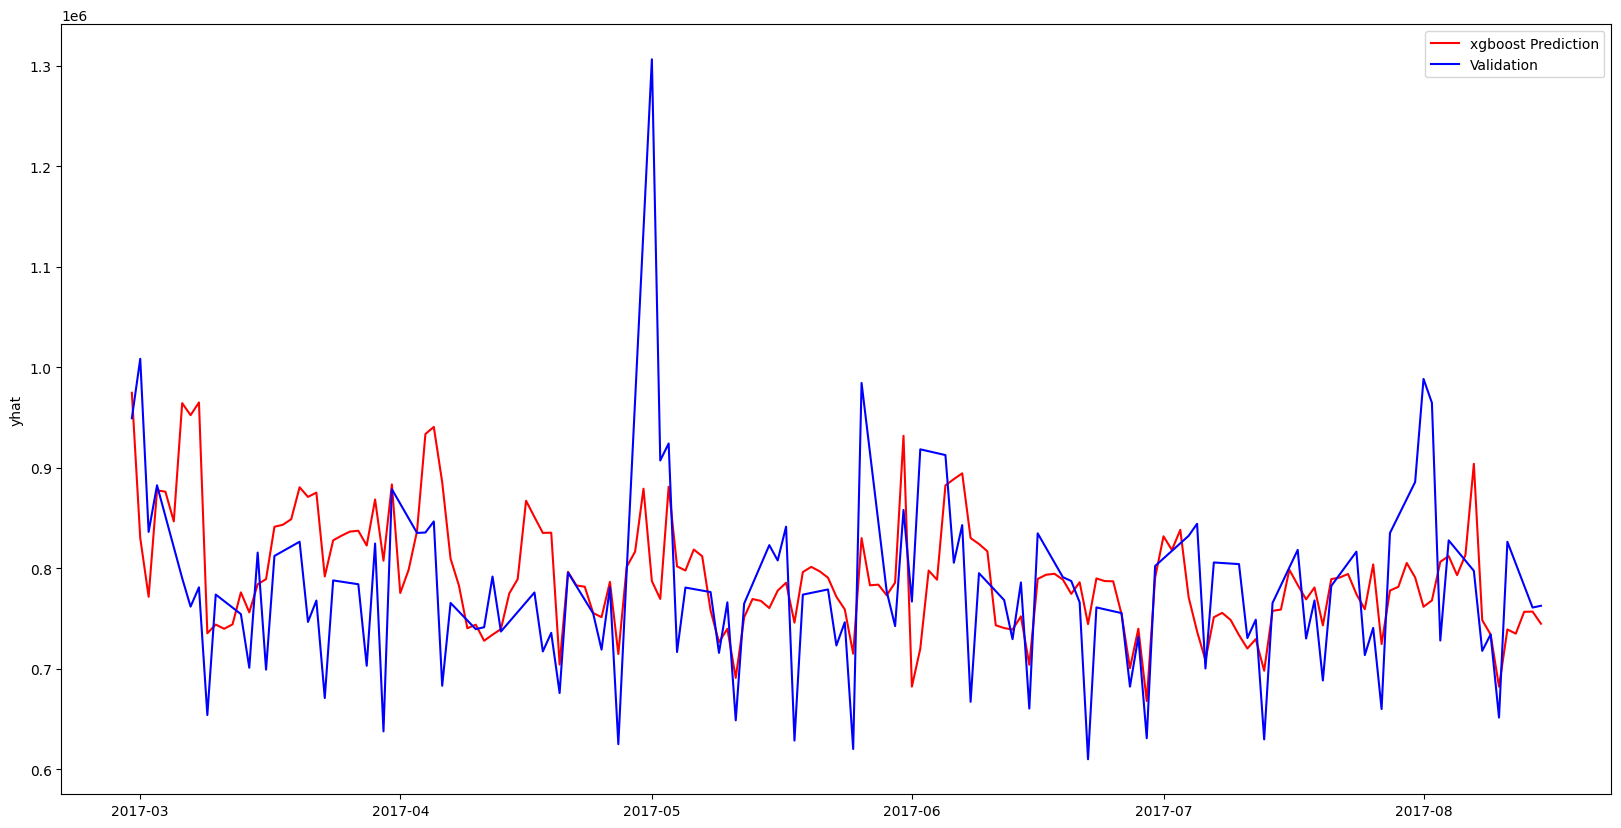

In [10]:
# Modele avec dataframe de base w/ moving average
pred = predict_and_plot("xgboost default - 2024-02-12 17:57")

Predicted 169 days
RMSE: 4151140927.416664
R2: -0.4604110117313275


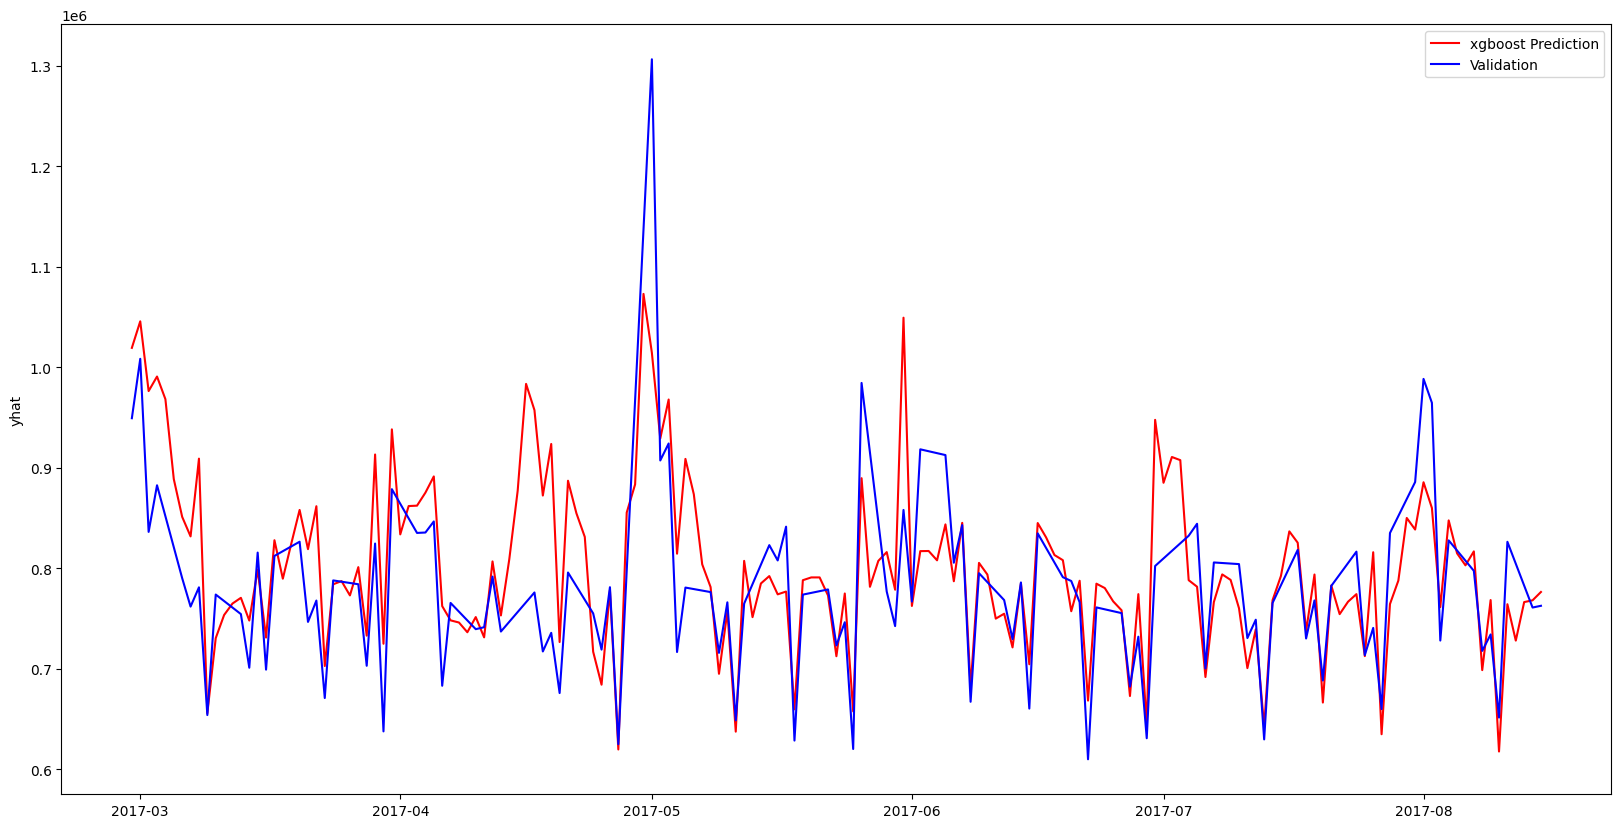

In [12]:
# Best model wo earthquake
pred = predict_and_plot("xgboost best_params - 2024-02-01 21:24")

Predicted 169 days
RMSE: 3353398434.5180197
R2: -0.5641061336673557


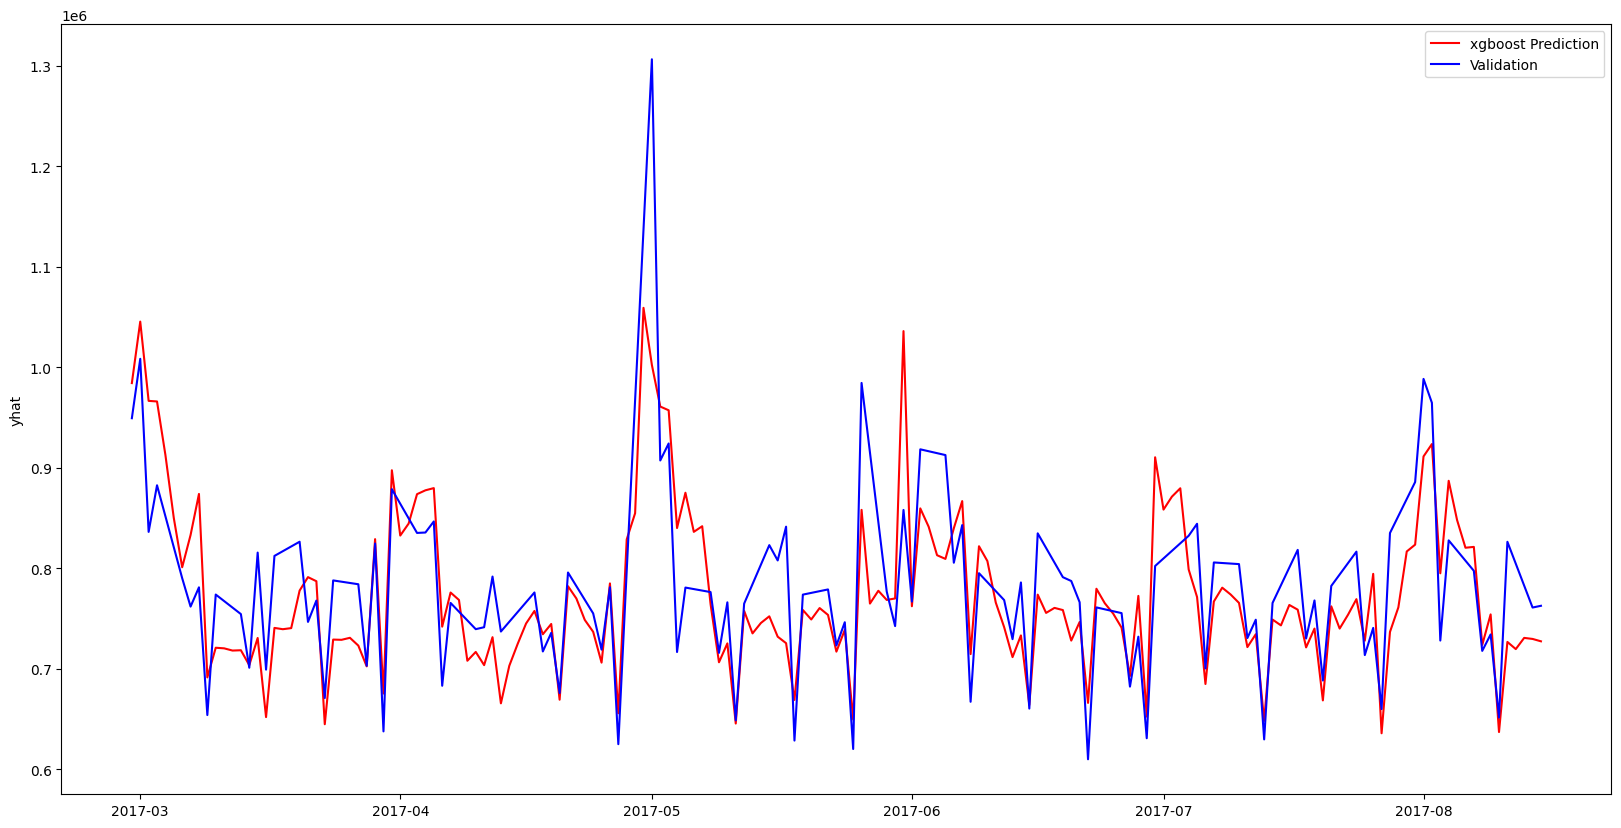

In [13]:
# Best model w/ earthquake
pred = predict_and_plot("xgboost best_params_earthquake - 2024-02-07 10:23")

Predicted 169 days
RMSE: 3254030690.784152
R2: 0.5770225200886825


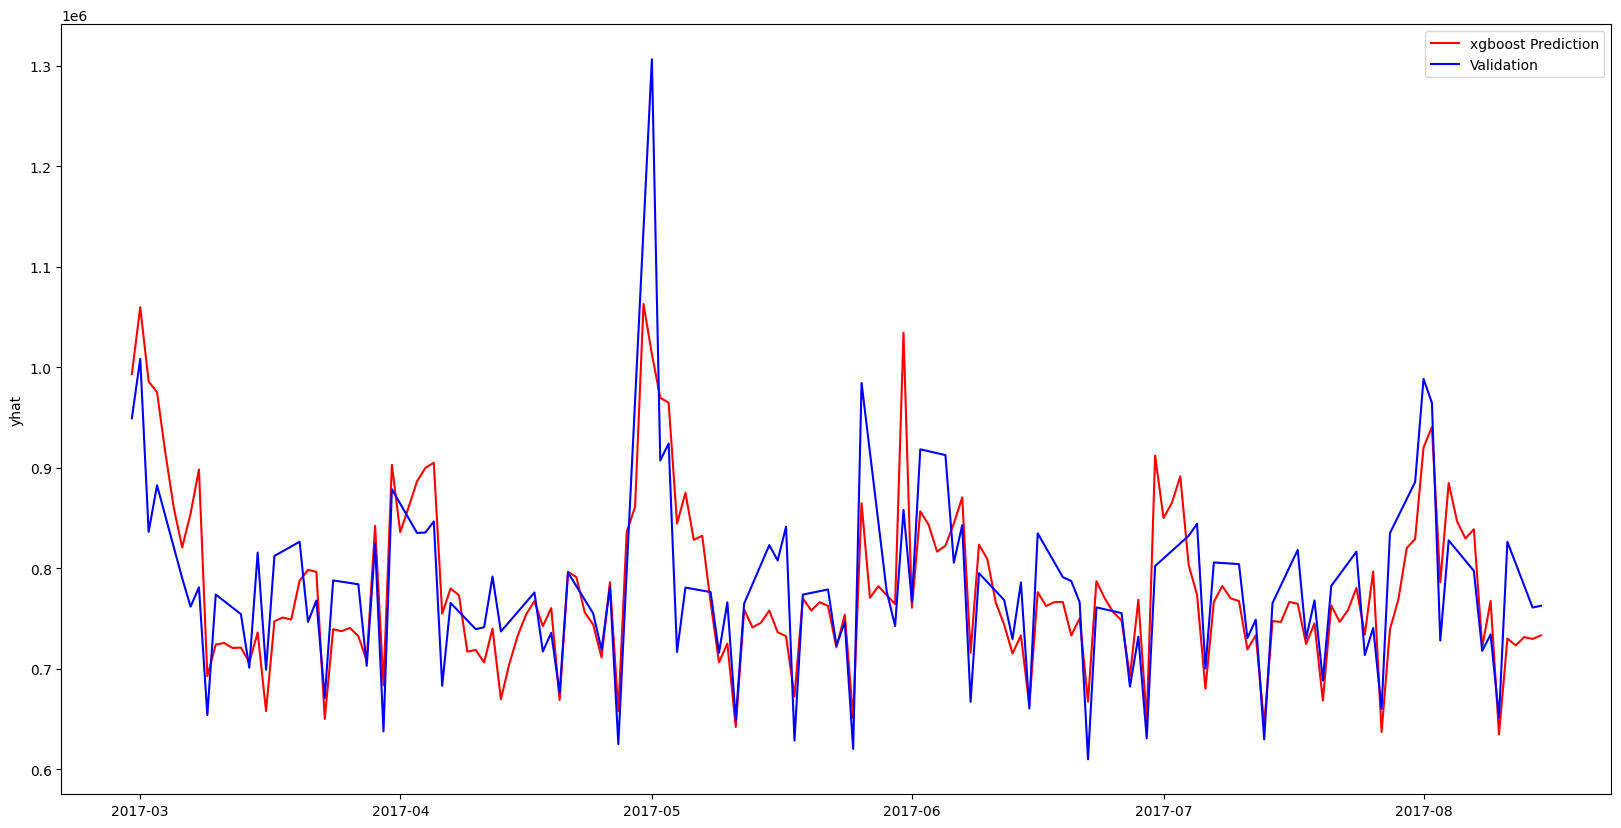

In [24]:
# Best model wo cluster
pred = predict_and_plot("xgboost best_params_earthquake - 2024-02-09 13:39")

<Axes: title={'center': 'R2 score for each model'}, xlabel='XGboost Model', ylabel='R2'>

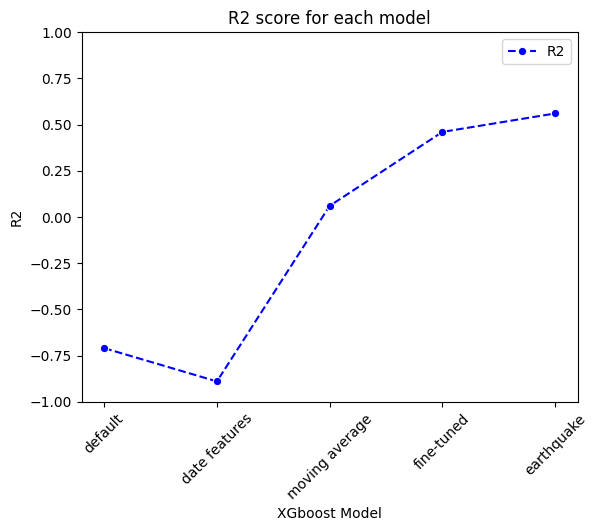

In [67]:
x = [1, 2, 3, 4, 5]
y = [-0.71, -0.89, 0.06, 0.46, 0.56]

plt.ylim(-1, 1)
plt.xlabel("XGboost Model")
plt.ylabel("R2")
plt.title("R2 score for each model")
plt.xticks(rotation=45)
plt.xticks(x, ["default", "date features", "moving average", "fine-tuned", "earthquake",])
sns.lineplot(x=x, y=y, color="blue", label="R2", marker="o", linestyle="--")